
# Project: Investigate a Dataset - NoShowAppointments

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The aim of this project is to examine a dataset containing more than 100,000 medical appointments in Brazil to determine what factors may contribute to a patient missing their appointments. The dataset includes the following patient characteristics,

- PatientId: patient identification number
- AppointmentID: patient appointment number
- Gender: patient gender (M/F)
- ScheduledDay: date and time of the appointment scheduling
- AppointmentDay: date (no timestamp) of the appointment
- Age: patient's age
- Neighborhood: hospital location
- Scholarship: patient enrollment in a scholarship program giving financial aid
- Hipertension: patient diagnosis of hypertension
- Diabetes: patient diagnosis of diabetes
- Alcoholism: patient diagnosis of alcoholism
- Handcap: patient diagnosis of ableism
- SMS_received: number from a SMS text reminder service
- Show-up: whether the patient made the appointment

Based on the specified parameters, we can explore the following questions:

1. Is there a temporal relationship between the date (scheduled or appointment) and attendance?
2. Are there any direct relationships between the patient's medical conditions (such as hypertension, diabetes, etc.), their use of SMS services, or their gender with their appointment attendance?
3. Is there a particular age group that is more likely to miss their appointment?
4. Is there a specific neighborhood where patients are more likely to miss their appointment?


In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

The csv file acquired from a url source, (https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd2e9a_noshowappointments-kagglev2-may-2016/noshowappointments-kagglev2-may-2016.csv). 


In [191]:
##Fetch dataset 
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd2e9a_noshowappointments-kagglev2-may-2016/noshowappointments-kagglev2-may-2016.csv'
df = pd.read_csv(url)


### Data Cleaning

The initial stage of data cleaning involves checking for null and duplicate entries, which found none. Although approximately 4% of the data comprises duplicate patient identification numbers, no identical rows or appointment numbers were found. As every appointment number is unique and probably generated systematically by each hospital, we can discard this column. 
To enhance our analysis workflow, we will rectify misspellings and naming inconsistencies by renaming columns. Furthermore, we will modify the data types of the following columns.

- PatientId: string -> integer
- Gender: sting -> bool (True if Male)
- ScheduledDay: sting -> datetime 		 
- AppointmentDay: sting -> datetime  	
- Scholarship: integer -> bool (True if 1)
- Hipertension: integer -> bool (True if 1)
- Diabetes: integer -> bool (True if 1)
- Alcoholism: integer -> bool (True if 1)
- Handcap: integer -> bool (True if 1)
- SMS_received: integer -> bool (True if 1)

Finally, the dataset has been divided into two subsets - one consisting of patients who attended their appointment (“Shows”) and the other comprising patients who did not (“No Shows’).


In [192]:
##Clean dataset
#check duplicates and null
print('num of null=',sum(df.isnull().any()))
print('num of dupl=',sum(df.duplicated()))
#check identification columns
print('dupl of Pa ID=',sum(df['PatientId'].duplicated())/df.shape[0],'%')
print('dupl of App ID=',sum(df['AppointmentID'].duplicated())/df.shape[0],'%')
df.drop(columns=['AppointmentID'],axis=1,inplace=True)
#rename columns
df.rename(columns={'PatientId':'Patient_Id','ScheduledDay':'Scheduled_Day','AppointmentDay':'Appointment_Day',
                    'Hipertension':'Hypertension','Handcap':'Handicap'},inplace=True)
df.rename(columns=lambda x: x.strip().lower().replace('-','_'),inplace=True)

##Change datatype
df['patient_id'] = df['patient_id'].apply(lambda x: str(int(x)))
df['scheduled_day'] = pd.to_datetime(df['scheduled_day']) #str -> timestamp
df['appointment_day'] = pd.to_datetime(df['appointment_day']) #str -> timestamp
df['no_show'] = df['no_show']=='Yes' #str -> bool
df['male'] = df['gender']=='M' #str -> bool
columns = ['scholarship','hypertension','diabetes','handicap','alcoholism','sms_received']
for c in columns:
    df[c] = df[c].astype(bool) #int -> bool


##Split shows and no_shows
#split dataset
df_show = df.query('no_show == False').drop(columns=['no_show'],axis=1)
df_noshow = df.query('no_show == True').drop(columns=['no_show'],axis=1)

num of null= 0
num of dupl= 0
dupl of Pa ID= 0.4363458702398509 %
dupl of App ID= 0.0 %


<a id='eda'></a>
## Exploratory Data Analysis

With the data separated into “Shows” and “No Shows’, we can see that the “No Shows” constitute 25% of the original, combined dataset. Next we will revisit the four proposed questions to find potential relationships in the dataset.

### 1. Temporal Relationship

In [194]:
#calculate ratio of no shows
num_shows = df_show.shape[0]
num_noshows = df_noshow.shape[0]
print('Percent of no shows:',num_noshows/num_shows*100,'%')
print('Number of shows:',num_shows)
print('Number of no shows:',num_noshows)
for df in [df_show, df_noshow]:
    print(df['scheduled_day'].describe())
    print(df['appointment_day'].describe())

Percent of no shows: 25.302693633230543 %
Number of shows: 88208
Number of no shows: 22319
count                   88208
unique                  83708
top       2016-03-29 10:44:23
freq                       11
first     2015-11-10 07:13:56
last      2016-06-08 20:07:23
Name: scheduled_day, dtype: object
count                   88208
unique                     27
top       2016-06-06 00:00:00
freq                     3819
first     2016-04-29 00:00:00
last      2016-06-08 00:00:00
Name: appointment_day, dtype: object
count                   22319
unique                  21180
top       2016-04-25 17:17:46
freq                       21
first     2015-12-03 08:17:28
last      2016-06-08 16:18:12
Name: scheduled_day, dtype: object
count                   22319
unique                     27
top       2016-05-16 00:00:00
freq                     1049
first     2016-04-29 00:00:00
last      2016-06-08 00:00:00
Name: appointment_day, dtype: object


The range of the appointment dates span April 29, 2016 to June 8 2016, while the scheduled dates range November 11, 2015 to June 8 2016. Five entries include a scheduling date listed after the appointment date, which will be dropped from the following analysis. Some potential relationships to consider are the schedule/appointment weekday (i.e., scheduled_weekday and appointment_weekday), schedule/appointment julian day (i.e., scheduled_jday and appointment_jday), scheduled hour (i.e., hour_of_day), and days between scheduling and appointment (i.e., days_ahead). 



In [195]:
## Explore appointment/schedule times
#new columns
for df in [df_show, df_noshow]:
    #calculate days scheduled ahead
    df['scheduled_day'] = pd.to_datetime(df['scheduled_day']) #str -> timestamp
    df['appointment_day'] = pd.to_datetime(df['appointment_day']) #str -> timestamp
    df['days_ahead'] = df.appointment_day.dt.date-df.scheduled_day.dt.date
    df['days_ahead'] = df['days_ahead'].apply(lambda x: x.days)
    df.drop(df.loc[df['days_ahead']<0].index, inplace=True)#remove entries with schedule date after appointment
    print(df.days_ahead.describe())
    bin_names = ['Same day','Short wait','Moderate wait','Long wait','Extended wait']
    #bin days_ahead
    bins = [-1,0,4,11,23,180]
    df['day_bins'] = pd.cut(df['days_ahead'], bins, labels=bin_names)
    #weekday
    df['scheduled_weekday']= df.scheduled_day.dt.dayofweek
    df['appointment_weekday']= df.appointment_day.dt.dayofweek
    #julian date
    df['scheduled_jday']= df.scheduled_day.dt.dayofyear
    df['appointment_jday']= df.appointment_day.dt.dayofyear
    #hour of day
    df['hour_of_day']= df.scheduled_day.dt.hour
    #separate date time
    df['scheduled_time'] = df.scheduled_day.dt.time
    df['scheduled_day']  = df.scheduled_day.dt.date
    df['appointment_day']= df.appointment_day.dt.date
#calculate new ratio of no shows
num_shows = df_show.shape[0]
num_noshows = df_noshow.shape[0]

count    88208.000000
mean         8.754659
std         14.550398
min          0.000000
25%          0.000000
50%          2.000000
75%         12.000000
max        179.000000
Name: days_ahead, dtype: float64
count    22314.000000
mean        15.835484
std         16.605600
min          0.000000
25%          4.000000
50%         11.000000
75%         23.000000
max        179.000000
Name: days_ahead, dtype: float64


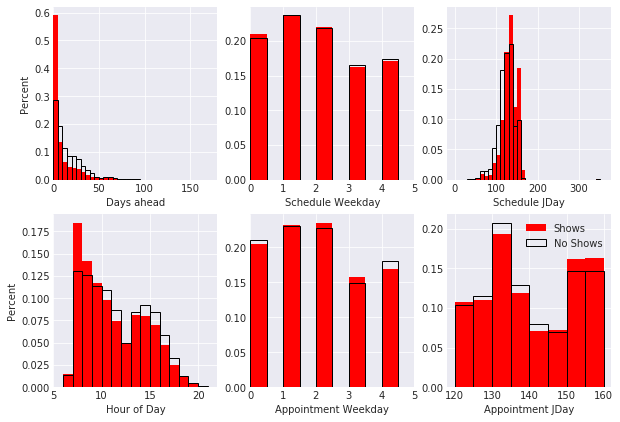

In [136]:
#plot times
fig, ax = plt.subplots(2,3,figsize=(10,7))
ax[0,0].hist(df_show['days_ahead'],bins=np.arange(30)*5,color='r',weights=np.ones(num_shows)/num_shows)
ax[0,0].hist(df_noshow['days_ahead'],bins=np.arange(30)*5,color='k',fill=False,weights=np.ones(num_noshows)/num_noshows)
ax[0,0].set_xlim([0,180])
ax[0,0].set_xlabel('Days ahead')
ax[0,0].set_ylabel('Percent')
ax[1,0].hist(df_show['hour_of_day'],bins=np.arange(24),color='r',weights=np.ones(num_shows)/num_shows)
ax[1,0].hist(df_noshow['hour_of_day'],bins=np.arange(24),color='k',fill=False,weights=np.ones(num_noshows)/num_noshows)
ax[1,0].set_xlim([5,22])
ax[1,0].set_xlabel('Hour of Day')
ax[1,0].set_ylabel('Percent')
ax[0,1].hist(df_show['scheduled_weekday'],color='r',weights=np.ones(num_shows)/num_shows)
ax[0,1].hist(df_noshow['scheduled_weekday'],color='k',fill=False,weights=np.ones(num_noshows)/num_noshows)
ax[0,1].set_xlim([0,5])
ax[0,1].set_xlabel('Schedule Weekday')
ax[1,1].hist(df_show['appointment_weekday'],color='r',weights=np.ones(num_shows)/num_shows)
ax[1,1].hist(df_noshow['appointment_weekday'],color='k',fill=False,weights=np.ones(num_noshows)/num_noshows)
ax[1,1].set_xlim([0,5])
ax[1,1].set_xlabel('Appointment Weekday')
ax[0,2].hist(df_show['scheduled_jday'],bins=np.arange(37)*10,color='r',weights=np.ones(num_shows)/num_shows)
ax[0,2].hist(df_noshow['scheduled_jday'],bins=np.arange(37)*10,color='k',fill=False,weights=np.ones(num_noshows)/num_noshows)
ax[0,2].set_xlabel('Schedule JDay')
ax[1,2].hist(df_show['appointment_jday'],bins=np.arange(9)*5+120,color='r',weights=np.ones(num_shows)/num_shows,label='Shows')
ax[1,2].hist(df_noshow['appointment_jday'],bins=np.arange(9)*5+120,color='k',fill=False,weights=np.ones(num_noshows)/num_noshows,label='No Shows')
ax[1,2].set_xlabel('Appointment JDay')
plt.legend()
plt.show()

In the subplots above, we've plotted the distributions of the six new temporal parameters. These histograms were normalized with Matplotlib's hist() weights=np.ones(len(data))/len(data). Histogram bin range and binsizes were chosen to best visualize each distribution; with hour of day, and both weekday plot having a binsize of one, appointment jday and days ahead a binsize of five, and schedule jday a binsize of ten.

In the two rightmost graphs, we observe that a higher proportion of “No Shows” were scheduled in April (jday ~ 90-120), and slightly higher percent of appointment dates missed in May (jday ~ 125-145). The middle two graphs show that the proportions of scheduling weekdays are nearly identical in the both separated subsets, while appointment weekdays indicated a possible increase of missed appointments on Mondays and Fridays, relative to the “Shows” subset. In the lower left, the scheduling hour of the day indicates an increased possibility for missed appointments if scheduled midday. Lastly in the upper left, we observe that 60% of the “Shows” subset have appointments scheduled within 5 days of the appointment, whereas the “No Shows” appear to increase as days increase. 

When rebinning the days of separation based on the quartiles of “No Shows”, with the "Same day" bin at 0 days ahead, "Short Wait" at 1-4 days, "Moderate Wait" 5-11 days, "Long Wait" 12-23 days, and "Extended Wait" 24-180 days. Plotted below, we see a positive correlation of missed appointments with increased wait times as well as a negative correlation in the “Shows” data. 


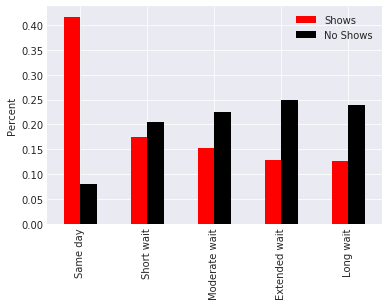

In [196]:
#plot day_bins
## note plt.hist plots columns out of order
##fig, ax = plt.subplots(figsize=(5,7))
##ax.hist(df_show['day_bins'],color='r',weights=np.ones(num_shows)/num_shows)
##ax.hist(df_noshow['day_bins'],color='b',fill=False,weights=np.ones(num_noshows)/num_noshows)
#make new df from proportion of binned values
df_days = pd.DataFrame()
df_days['Shows'] = df_show.day_bins.value_counts()/num_shows
df_days['No Shows'] = df_noshow.day_bins.value_counts()/num_noshows
ax = df_days.plot.bar(color=['r','k'])
ax.set_ylabel('Percent')
plt.legend()
plt.show()

### 2. Patient Attributes
Next we consider the proportions of patient attributes in both datasets, plotted below. The only attribute that appears to be associated with the “No Shows” data is paradoxically the SMS texting system. 

                 Shows  No Shows
hypertension  0.204392  0.169042
diabetes      0.073837  0.064085
alcoholism    0.030417  0.030340
handicap      0.020792  0.018150
sms_received  0.291334  0.438469
male          0.351011  0.346106


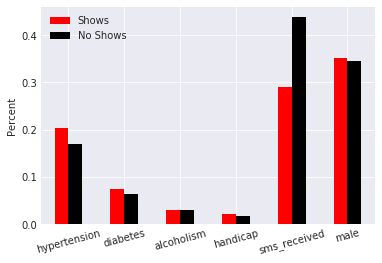

In [197]:
## Explore Patient Attributes
pos = df_show.columns[7:13]
#make new df from proportion of True values
df_attr = pd.DataFrame()
df_tmp = df_show[pos].apply(pd.Series.value_counts)/num_shows
df_attr['Shows'] = df_tmp.iloc[1].T #second column contains True value counts
#add column of Trues for no shows
df_tmp = df_noshow[pos].apply(pd.Series.value_counts)/num_noshows
df_attr['No Shows'] = df_tmp.iloc[1].T
print(df_attr)
#plot
ax = df_attr.plot.bar(rot=15,color=['r','k'])
ax.set_ylabel('Percent')
plt.show()

### 3. Age groups
Looking at the distribution of patient’s ages, there is one entry in the "Shows" subset with a neagtive age which we remove. Plotted below, we observe a higher portion of missed appointments from younger patients. After binning the age data into the “No Shows” quartiles, plus babies, we see that adolescence and young adults miss appointments more than their older counterparts.


count    88207.000000
mean        37.790504
std         23.338645
min          0.000000
25%         18.000000
50%         38.000000
75%         56.000000
max        115.000000
Name: age, dtype: float64
count    22314.000000
mean        34.317872
std         21.965009
min          0.000000
25%         16.000000
50%         33.000000
75%         51.000000
max        115.000000
Name: age, dtype: float64
                      Shows  No Shows
Elderly Adult      0.276271  0.204311
Middle-aged Adult  0.246001  0.238146
Young Adult        0.235321  0.288832
Adolecent          0.172979  0.210182
Baby               0.069428  0.058528


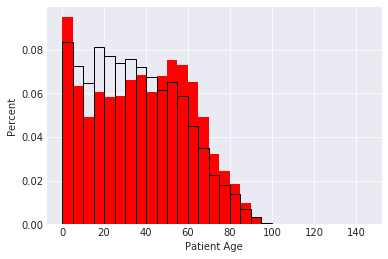

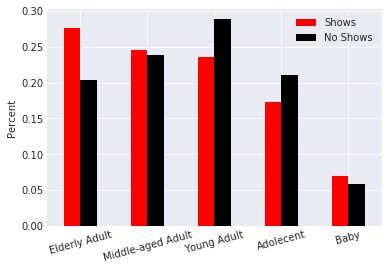

In [199]:
## Explore Ages
for df in [df_show, df_noshow]:
    print(df['age'].describe())
    df.drop(df.loc[df['age']<0].index, inplace=True)#remove entries with schedule date after appointment
#calculate new count without negative ages
num_shows = df_show.shape[0]
num_noshows = df_noshow.shape[0]
num_total = num_shows + num_noshows
#binned ages
df_ages = pd.DataFrame()
bin_names = ['Baby','Adolecent','Young Adult','Middle-aged Adult','Elderly Adult']
bins = [-1,2,17,36,54,115]
df_ages['Shows'] = pd.cut(df_show['age'], bins, labels=bin_names).value_counts()/num_shows
df_ages['No Shows'] = pd.cut(df_noshow['age'], bins, labels=bin_names).value_counts()/num_noshows
print(df_ages)
#plot ages
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.hist(df_show['age'],bins=np.arange(30)*5,color='r',weights=np.ones(num_shows)/num_shows)
ax1.hist(df_noshow['age'],bins=np.arange(30)*5,color='k',fill=False,weights=np.ones(num_noshows)/num_noshows)
ax1.set_xlabel('Patient Age')
ax1.set_ylabel('Percent')
ax2 = df_ages.plot.bar(rot=15,color=['r','k'])
ax2.set_ylabel('Percent')
plt.show()

### 4.Neighborhoods
In the neighborhood data, we see the average ratio of missed appointments lowers to 20%, with nine neighborhoods having ratios greater than one standard deviation about the mean (ratio > 19.80 + 0.03). Those high-ratio neighborhoods are also plotted below.


Ratios
count    79.000000
mean      0.197950
std       0.031706
min       0.085714
25%       0.180276
50%       0.197588
75%       0.216972
max       0.289185
Name: ratio, dtype: float64
                   show  noshow     ratio
ITARARÉ            2591   923.0  0.262664
JESUS DE NAZARETH  2157   696.0  0.243954
CARATOÍRA          1974   591.0  0.230409
ANDORINHAS         1741   521.0  0.230327
ILHA DO PRÍNCIPE   1734   532.0  0.234775
SANTOS DUMONT       907   369.0  0.289185
SANTA CLARA         372   134.0  0.264822
SANTA CECÍLIA       325   123.0  0.274554
HORTO               133    42.0  0.240000


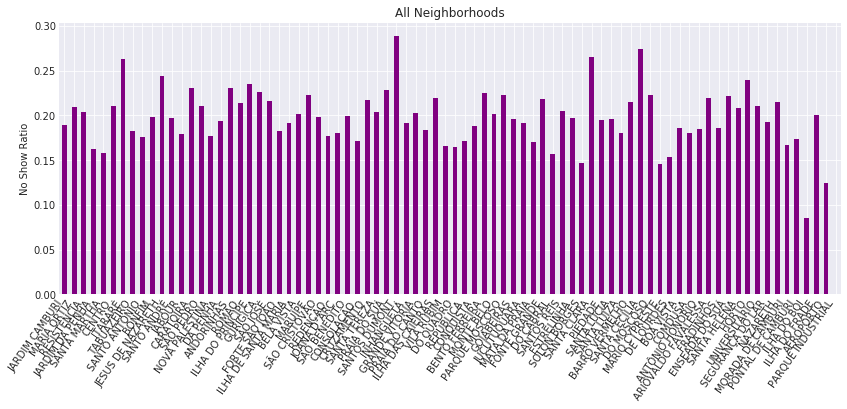

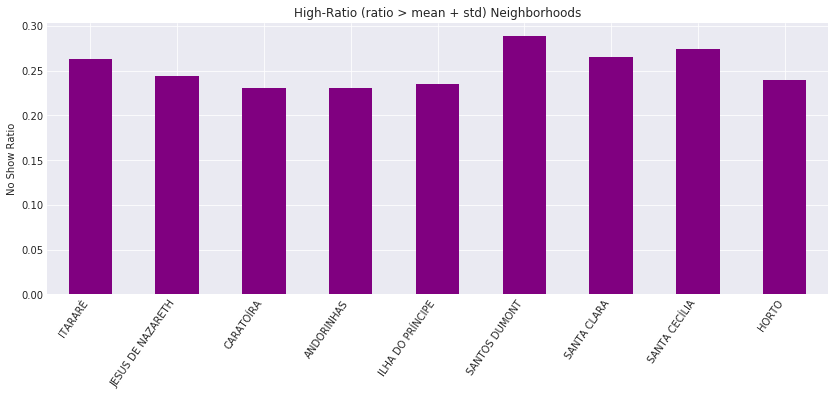

In [202]:
##Neighbourhood
#make new df from value counts
df_neig = pd.DataFrame()
df_neig['show'] = df_show['neighbourhood'].value_counts()
#add column for no shows
df_neig['noshow'] = df_noshow['neighbourhood'].value_counts()
#new column of No Show ratio
df_neig['ratio'] = df_neig['noshow']/(df_neig['show']+df_neig['noshow'])
print('Ratios')
print(df_neig['ratio'].describe())
std = df_neig['ratio'].std()
mean = df_neig['ratio'].mean()
df_hr_neig = df_neig[df_neig.ratio > mean+std]
print(df_hr_neig.to_string())
#plot
fig, ax = plt.subplots(figsize=(14,5))
df_neig['ratio'].plot.bar(rot=15,color='purple')
ax.set_xticklabels(ax.get_xticklabels(),rotation=55,ha='right')
ax.set_ylabel('No Show Ratio')
ax.set_title('All Neighborhoods')
fig, ax = plt.subplots(figsize=(14,5))
df_hr_neig['ratio'].plot.bar(rot=15,color='purple')
ax.set_xticklabels(ax.get_xticklabels(),rotation=55,ha='right')
ax.set_ylabel('No Show Ratio')
ax.set_title('High-Ratio (ratio > mean + std) Neighborhoods')
plt.show()


<a id='conclusions'></a>
## Conclusions

In conclusion, the raw dataset contained no null or duplicate data but during the data exploration some entries listed scheduling dates which followed the appointment date, thus were dropped. Some data hygiene was performed to make columns more uniform and easier to access. 

In the exploration, we set out to explore the following questions,

1. Is there a temporal relationship?
2. Are there any direct relationships with the patient's attributes?
3. Is there a particular age group associated with missed appointments?
4. Is there a specific neighborhood associated with missed appointments?

Our analysis found that patients had a higher chance of missing their appointment, the long they waited between scheduling their appointment. Additionally, patients that received a SMS text reminder had missed appointments at a higher rate than those who had not received a reminder; however, this is likely indirectly related to the previous observation. Younger patients appear to miss their appointments more often than older patients. And lastly, there were nine neighborhoods associated with statistically higher ratios of missed appointments.

A limitation from digging deeper into why people missed appointment is in not knowing the reason for each appointment. It's possible that missed appoinments may be strongly associated with low-priority checkups. 




## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])